# AM

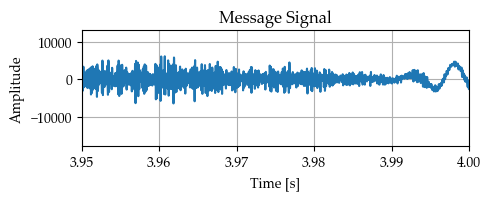

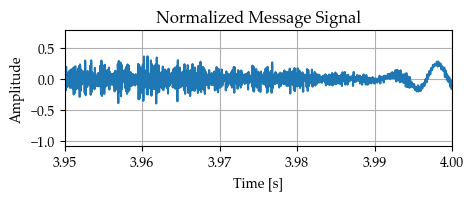

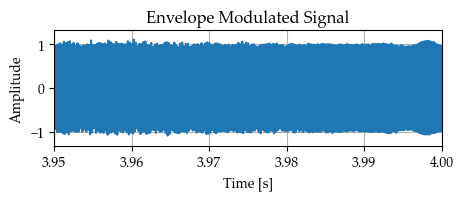

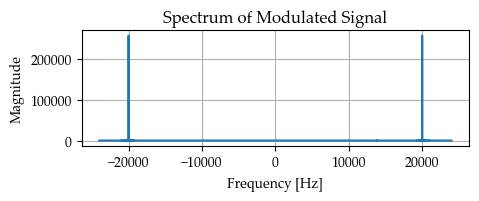

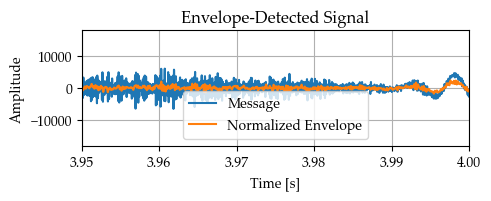

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = [5,1.5]

mod_index = 0.3 # modulation index specified by the problem

# 1. Generate Sinusoidal Message Signal
fs, message = wavfile.read('audio.wav')
new_message = np.zeros(3*len(message)) #!! 补长信号，以补偿滤波器的误差
new_message[len(message):2*len(message)] = message
message = new_message
t = np.arange(0, len(message)/fs, 1/fs)
fc = 20000

# 2. Perform Envelope Modulation
carrier = np.cos(2 * np.pi * fc * t)
message_normalized = new_message / np.max(np.abs(new_message))
modulated_signal = (1 + mod_index * message_normalized) * carrier

# 3. Add AWGN Noise
noise_power = 0.0001  # Noise power
noise = np.sqrt(noise_power) * np.random.normal(size=len(t))
noisy_signal = modulated_signal + noise

# 4. Envelope Detection
# use magnitude of Hilbert transform
# envelope = np.abs(hilbert(noisy_signal))

# envelope_no_offset = envelope - np.mean(envelope)  # Remove DC offset
# envelope_normalized = envelope_no_offset / np.max(np.abs(envelope_no_offset)) * np.max(np.abs(message))  # Normalize

# use lpf
b, a = butter(8, 5000, fs=fs, btype='lowpass', analog=False)
envelope = filtfilt(b, a, np.abs(noisy_signal))
envelope_no_offset = envelope - np.mean(envelope)  # Remove DC offset
envelope_normalized = envelope_no_offset / np.max(np.abs(envelope_no_offset)) * np.max(np.abs(message))  # Normalize

# 5. Plotting
# plot the message signal
plt.figure()
plt.plot(t, message)
plt.title('Message Signal')
plt.xlabel('Time [s]')
plt.xlim([3.95, 4])
plt.ylabel('Amplitude')

# plot normalized message signal
plt.figure()
plt.plot(t, message_normalized)
plt.title('Normalized Message Signal')
plt.xlabel('Time [s]')
plt.xlim([3.95, 4])
plt.ylabel('Amplitude')

# Plot the envelope modulated signal
plt.figure()
plt.plot(t, modulated_signal)
plt.title('Envelope Modulated Signal')
plt.xlabel('Time [s]')
plt.xlim([3.95, 4])
plt.ylabel('Amplitude')

# Plot the spectrum
plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
modulated_spectrum = fftshift(fft(modulated_signal))
plt.plot(f, np.abs(modulated_spectrum))
plt.title('Spectrum of Modulated Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Plot the envelope-detected signal after low-pass filtering
plt.figure()
plt.plot(t, message, label='Message')
plt.plot(t, envelope_normalized, label='Normalized Envelope')
plt.title('Envelope-Detected Signal')
plt.xlabel('Time [s]')
plt.xlim([3.95, 4])
plt.ylabel('Amplitude')
plt.legend()
plt.show()


# write the demodulated signal to a wav file as int16
wavfile.write('am_demodulated.wav', fs, envelope_normalized.astype(np.int16))

# SNR calculation and comparison will be done next.
# modulated_signal, noisy_signal, envelope, modulated_spectrum

In [2]:
def snr(signal, noise):
    """ Calculate Signal-to-Noise Ratio (SNR) """
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = np.mean(np.abs(noise) ** 2)
    return 10 * np.log10(signal_power / noise_power)

# Calculate SNR before detection (pre-detection SNR)
pre_detection_snr = snr(modulated_signal, noise)

# For post-detection SNR, we consider the envelope-detected signal and noise
# Assuming low-pass filter removes most of the high-frequency noise components
post_detection_snr = snr(envelope, noise)

# Theoretical SNR
#?? How does the following relation come up
# For AM, theoretical SNR post-detection is (1.5 * modulation_index^2) times the pre-detection SNR
theoretical_snr_low = 1.5 * (1+mod_index**2) * pre_detection_snr #??
theoretical_snr_high = 1.5 * pre_detection_snr  # For high modulation index close to 1

# theoretical_snr_textbook = 

pre_detection_snr, post_detection_snr, theoretical_snr_low, theoretical_snr_high

#todo: 可以打一个SNR-Noise Power的图，看看SNR和Noise Power的关系

#todo: 打一个pre- 和post-detection SNR的关系图

(36.99389567581914, 35.89842971555525, 60.485019429964304, 55.490843513728706)

# FM

FM Demodulation is still in progress. Some test cases show that the popular implementation has fairly great errors when encountering multiple frequency components. This is especially the case if the message signal is not periodical.

## Modulation

### Read the audio wave

(44100, 15000)

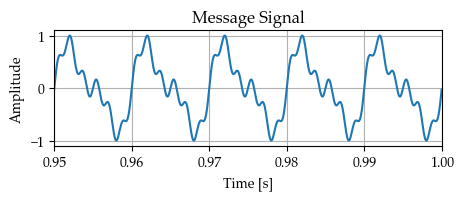

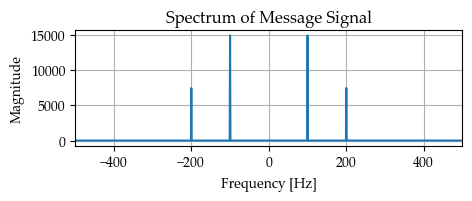

In [3]:
# read the message signal from the wav file
# fs, message = wavfile.read('audio.wav')
fs = 44100
freq_components = np.array([100, 200, 600])
fmax= np.max(freq_components)
amplitudes = np.array([1, 0.5, 0.25])
t = np.arange(0, 1, 1/fs)
message = np.zeros(len(t))
for i in range(len(freq_components)):
    message += amplitudes[i] * np.sin(2 * np.pi * freq_components[i] * t)
message_normalized = message / np.max(np.abs(message))
Am = np.max(message)
b, a = butter(8, 5000, fs=fs, btype='low', analog=False)
message_filtered = filtfilt(b, a, message_normalized)
t = np.arange(0, len(message)/fs, 1/fs)
fc = 15000
freq = np.linspace(-fs/2, fs/2, len(t))
message_spectrum = fftshift(fft(message_filtered))

# plot the message signal
plt.figure()
plt.plot(t, message_normalized)
plt.title('Message Signal')
plt.xlabel('Time [s]')
plt.xlim([0.95, 1])
plt.ylabel('Amplitude')

# Plot the spectrum
plt.figure()
plt.plot(freq, np.abs(message_spectrum))
plt.title('Spectrum of Message Signal')
plt.xlim([-500, 500])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

fs, fc

### Modulate with carrier wave

Frequency deviation = 4500.00 Hz
Modulation Sensitivity = 4500.00 rad/s/V


Text(0, 0.5, 'Magnitude')

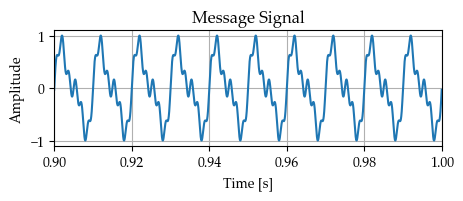

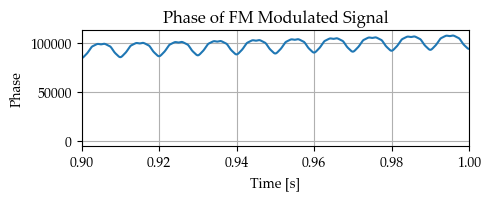

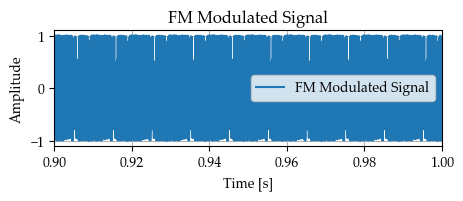

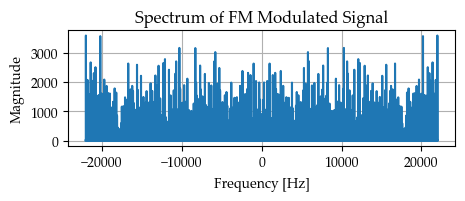

In [4]:
# amplitude of message signal
Am = np.max(np.abs(message_normalized))

# calculate modulation sensitivity
deviation = mod_index*fc
kf = deviation / Am
print('Frequency deviation = {:.2f} Hz'.format(deviation))
print('Modulation Sensitivity = {:.2f} rad/s/V'.format(kf))

# integrate the message signal to get the phase
message_integral = np.zeros(len(t))
for i in range(1, len(t)):
    message_integral[i] = message_integral[i-1] + message_normalized[i] * 1/fs
message_integral_normalized = 0.5 * message_integral / np.max(np.abs(message_integral))
phi = 2 * np.pi * kf * message_integral_normalized + 2 * np.pi * fc * t
fm_modulated_signal = np.cos(phi)

# plot the message signal
plt.figure()
plt.plot(t, message_normalized)
plt.title('Message Signal')
plt.xlabel('Time [s]')
plt.xlim([0.9, 1])
plt.ylabel('Amplitude')

# plot the phase
plt.figure()
plt.plot(t, phi)
plt.title('Phase of FM Modulated Signal')
plt.xlabel('Time [s]')
plt.xlim([0.9, 1])
plt.ylabel('Phase')

# plot the FM modulated signal
plt.figure()
plt.plot(t, fm_modulated_signal, label='FM Modulated Signal')
plt.title('FM Modulated Signal')
plt.xlabel('Time [s]')
plt.legend()
plt.xlim([0.9, 1])
plt.ylabel('Amplitude')

# Plot the spectrum
plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
fm_modulated_spectrum = fftshift(fft(fm_modulated_signal))
plt.plot(f, np.abs(fm_modulated_spectrum))
plt.title('Spectrum of FM Modulated Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')


## Demodulation

Text(0, 0.5, 'Phase')

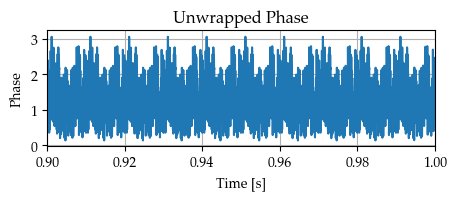

In [5]:
# demodulate
# use a differentiator to get the derivative of the phase
received_signal = fm_modulated_signal
received_signal_diff = np.diff(received_signal)
received_signal_diff = np.append(received_signal_diff, received_signal_diff[-1])
# received_signal_diff_normalized = received_signal_diff / np.max(np.abs(received_signal_diff))

# extract the phase
phi_received = np.abs(hilbert(received_signal_diff))
phi_received2 = np.abs(hilbert(phi_received))

# unwrap
# phi_unwrapped = np.unwrap(phi_received)

# plot the unwrapped phase
plt.figure()
plt.plot(t, phi_received2)
plt.title('Unwrapped Phase')
plt.xlabel('Time [s]')
plt.xlim([0.9, 1])
plt.ylabel('Phase')
